 # Detailed walk through for PtyRAD

 Chia-Hao Lee

cl2696@cornell.edu

Updated on 2024.09.19

Note: This notebook is designed for showcasing only the "reconstruction" mode, most of the wrapper class / functions are exposed so that you can see how it works.

# 01. Imports

In [1]:
import os
from random import shuffle

import numpy as np
import torch

GPUID = 0
DEVICE = torch.device("cuda:" + str(GPUID))
print("Execution device: ", DEVICE)
print("PyTorch version: ", torch.__version__)
print("CUDA available: ", torch.cuda.is_available())
print("CUDA version: ", torch.version.cuda)
print("CUDA device:", torch.cuda.get_device_name(GPUID))

Execution device:  cuda:0
PyTorch version:  2.1.0
CUDA available:  True
CUDA version:  12.1
CUDA device: Quadro P5000


In [2]:
work_dir = "H:\workspace\ptyrad"
os.chdir(work_dir)
print("Current working dir: ", os.getcwd())

Current working dir:  H:\workspace\ptyrad


In [3]:
from ptyrad.data_io import load_params
from ptyrad.initialization import Initializer
from ptyrad.models import PtychoAD
from ptyrad.optimization import CombinedConstraint, CombinedLoss, create_optimizer
from ptyrad.reconstruction import loss_logger, recon_step

from ptyrad.utils import (
    copy_params_to_dir,
    get_blob_size,
    make_batches,
    make_output_folder,
    parse_sec_to_time_str,
    save_results,
    select_scan_indices,
    time_sync,
    test_loss_fn,
)
from ptyrad.visualization import (
    plot_forward_pass,
    plot_pos_grouping,
    plot_scan_positions,
    plot_summary,
)

ptyrad version: v0.1.0-beta2.4


# 02. Initialize optimization

In [4]:
# exp_params = {
#     'kv'                : 80, # type: float, unit: kV. Acceleration voltage for relativistic electron wavelength calculation
#     'conv_angle'        : 24.9, # type: float, unit: mrad. Semi-convergence angle for probe-forming aperture
#     'Npix'              : 128, # type: integer, unit: px (k-space). Detector pixel number, EMPAD is 128. Only supports square detector for simplicity
#     'dx_spec'           : 0.1494, # type: float, unit: Ang. Real space pixel size calibration at specimen plane (object, probe, and probe positions share the same pixel size)
#     'defocus'           : 0, # type: float, unit: Ang. Defocus (-C1) aberration coefficient for the probe. Positive defocus here refers to actual underfocus or weaker lens strength following Kirkland/abtem/ptychoshelves convention
#     'c3'                : 0, # type: float, unit: Ang. Spherical aberration coefficient (Cs) for the probe
#     'z_distance'        : 12, # type: float, unit: Ang. Slice thickness for multislice ptychography. Typical values are between 1 to 20 Ang
#     'Nlayer'            : 1, # type: int, unit: #. Number of slices for multislice object
#     'N_scans'           : 16384, # type: int, unit: #. Number of probe positions (or equivalently diffraction patterns since 1 DP / position)
#     'N_scan_slow'       : 128, # type: int, unit: #. Number of scan position along slow scan direction. Usually it's the vertical direction of acquisition GUI
#     'N_scan_fast'       : 128, # type: int, unit: #. Number of scan position along fast scan direction. usually it's the horizontal direction of acquisition GUI
#     'scan_step_size'    : 0.4290, # type: float, unit: Ang. Step size between probe positions in a rectangular raster scan pattern
#     'scan_flipT'        : None, # type: None or list of 3 binary booleans (0 or 1) as [flipup, fliplr, transpose] just like PtychoShleves. Default value is None or equivalently [0,0,0]. This applies additional flip and transpose to initialized scan patterns. Note that modifing 'scan_flipT' would change the image orientation, so it's recommended to set this to None, and only use 'meas_flipT' to get the orientation correct
#     'scan_affine'       : None, # type: None or list of 4 floats as [scale, asymmetry, rotation, shear] just like PtychoShleves. Default is None or equivalently [1,0,0,0], rotation and shear are in unit of degree. This applies additional affine transformation to initialized scan patterns to correct sample drift and imperfect scan coils
#     'scan_rand_std'     : 0.15, # type: None or float, unit: px (real space). Randomize the initial guess of scan positions with Gaussian distributed displacement (std in px) to reduce raster grid pathology
#     'omode_max'         : 1, # type: int, unit: #. Maximum number of mixed object modes. Set to omode_max = 1 for single object state, omode_max > 1 for mixed-state object during initialization. For simulated initial object, it'll be generated with the specified number of object modes. For loaded object, the omode dimension would be capped at this number
#     'omode_init_occu'   : {'occu_type': 'uniform', 'init_occu': None}, # type: dict. Occupancy type and value for mixed-object modes. Typically we do 'uniform' for frozen phonon like configurations as {'occu_type': 'uniform', 'init_occu': None}. 'occu_type' can be either 'uniform' or 'custom', if 'custom', pass in the desired occupancy as an array to 'init_occu'
#     'pmode_max'         : 6, # type: int, unit: #. Maximum number of mixed probe modes. Set to pmode_max = 1 for single probe state, pmode_max > 1 for mixed-state probe during initialization. For simulated initial object, it'll be generated with the specified number of probe modes. For loaded probe, the pmode dimension would be capped at this number
#     'pmode_init_pows'   : [0.02], # type: list of 1 or a few (pmode_max) floats. Initial power for each additional probe modes. If set at [0.02], all additional probe modes would contain 2% of the total intensity. sum(pmode_init_pows) must be 1 if more than len(pmode_init_pows) > 1. See 'utils.make_mixed_probe' for more details
#     'probe_permute'     : None, # type: None or list of int. This applies additional permutation (reorder axes) for the initialized probe. The syntax is the same as np.transpose()
#     'meas_permute'           : None, # type: None or list of ints. This applies additional permutation (reorder axes) for the initialized diffraction patterns. The syntax is the same as np.transpose()
#     'meas_reshape'           : None, # type: None or list of 3 ints. This applies additional reshaping (rearrange elements) for the initialized diffraction patterns. The syntax is the same as np.reshape(). This is commonly needed to convert the 4D diffraction dataset (Ry,Rx,ky,kx) into 3D (N_scans,ky,kx)
#     'meas_flipT'             : [1,0,0], # type: None or list of 3 binary booleans (0 or 1) as [flipup, fliplr, transpose] just like PtychoShleves. Default is None or [0,0,0] but you may need to find the correct flip and transpose to match your dataset configuration. This applies additional flip and transpose to initialized diffraction patterns. It's suggested to use 'meas_flipT' to correct the dataset orientation and this is the only orientaiton-related value attached to output reconstruction folder name
#     'meas_crop'              : None, # type: None or (4,2) nested list of ints as [[scan_slow_start, scan_slow_end], [scan_fast_start, scan_fast_end], [ky_start, ky_end], [kx_start, kx_end]]. This applies additional cropping to the 4D dataset in both real and k-space. This is useful for reconstrucing a subset of real-space probe positions, or to crop the kMax of diffraction patterns. The syntax follows conventional numpy indexing so the upper bound is not included
#     'meas_resample'          : None, # type: None or list of 2 floats as [ky_zoom, kx_zoom]. This applies additional resampling of initialized diffraction patterns along ky and kx directions. This is useful for changing the k-space sampling of diffraction patterns. See scipy.ndimage.zoom for more details
#     'meas_add_source_size'   : None, # type: None or float, unit: Ang. This adds additional spatial partial coherence to diffraction patterns by applying Gaussian blur along scan directions. The provided value is used as the std (sigma) for the Gaussian blurring kernel in real space. Note that FWHM ~ 2.355 std, so a std of 0.34 Ang is equivalent to a source size (FWHM) of 0.8 Ang
#     'meas_add_detector_blur' : None, # type: None or float, unit: px (k-space). This adds additional detector blur to diffraction patterns to emulate the PSF on detector. The provided value is used as the std (sigma) for the Gaussian blurring kernel in k-space. Note that this is applied to the "measured", or "ground truth" diffraction pattern and is different from 'model_params['detector_blur_std']' that applies to the forward simulated diffraction pattern
#     'meas_add_poisson_noise' : None, # type: None or float, unit: electrons/Ang^2. This applies additional Poisson noise to diffraction patterns to emulate the Poisson statistics of electron dose. This is useful when you have a noise-free simulated dataset and want to try ptychographic reconstruciton at different dose conditions
# }

# source_params = {
#     'measurements_source': 'raw', # type: str. Data type of the measurements (diffraction patterns). Currently supporting 'raw', 'hdf5', 'mat', 'tif', and 'custom'. 
#     'measurements_params': {'path': 'data/tBL_WSe2/Fig_1h_24.9mrad_Themis/scan_x128_y128.raw'}, # type: dict, or numpy array. For 'measurements_source' = 'mat', or 'hdf5', provide the 'path' and 'key' in a dict {'path': <PATH_TO_DATA>, 'key': <DATA_KEY>} to retrieve the data matrix. 'tif' would only need the {'path':<PATH_TO_DATA>}. For 'raw' you can optionally pass in 'shape':(N,height,width), 'offset':int, 'gap':int to load the .raw files from EMPAD1 and pre-processed EMPAD datasets. For example, {'path': <PATH_TO_DATA>, 'offset':0, 'gap':0} can be used to load pre-processed EMPAD2 raw dataset with no gap between binary diffraction patterns. The 'shape' will be automatically filled in from 'exp_params', while 'offset':0, and 'gap':1024 are default values for EMPAD1 datasets. For py4dstem processed diffraction patterns (hdf5), use '/datacube_root/datacube/data' for your 'key'. For 'custom' source, pass the numpy array to the 'measurements_params' entry after you load this .yml as a dict
#     'obj_source'         : 'simu', # type: str. Data source of the object. Currently supporting 'simu', 'PtyRAD', 'PtyShv', and 'custom'
#     'obj_params'         : None, # type: None, list of 4 ints, str, or numpy array. Parameters of the object loading/initialization. For 'simu' (simulating object), provide a list of 4 ints (omode, Nz, Ny, Nx) to specify the object shape or None to let PtyRAD determine it (None is suggested and is consistent with how PtyShv creates their initial object). For loading object from 'PtyRAD' or 'PtyShv', provide a str of <PATH_TO_RECONSTRUCTION_FILE>. For 'custom' object source, pass the 4D numpy array to the 'obj_params' entry after you load this .yml as a dict
#     'probe_source'       : 'simu', # type: str. Data source of the probe. Currently supporting 'simu', 'PtyRAD', 'PtyShv', and 'custom'
#     'probe_params'       : None, # type: None, dict, str, or numpy array. Parameters of the probe loading/initialization. For 'simu' (simulating probe), provide a dict of 'probe_simu_params' to specify the simulation parameters (see 'utils/make_stem_probe' for more details) or None to use only basic paramaters like kV, conv_angle, defocus and c3. For loading probe from 'PtyRAD' or 'PtyShv', provide a str of <PATH_TO_RECONSTRUCTION_FILE>. For 'custom' probe source, pass the 3D numpy array to the 'probe_params' entry after you load this .yml as a dict
#     'pos_source'         : 'simu', # type: str. Data source of the probe positions. Currently supporting 'simu', 'PtyRAD', 'PtyShv', and 'custom'
#     'pos_params'         : None, # # type: None, str, or numpy array. Parameters of the probe positions loading/initialization. For 'simu' (simulating probe positions), provide None and check whether you need 'scan_flipT'. The positions would be simulated based on 'N_scan_slow', 'N_scan_fast', 'scan_step_size', and 'scan_affine'. For loading probe positions from 'PtyRAD' or 'PtyShv', provide a str of <PATH_TO_RECONSTRUCTION_FILE>. For 'custom' probe position source, pass the (N_scans,2) numpy array to the 'pos_params' entry after you load this .yml as a dict
#     'tilt_source'        : 'simu', # type: str. Data source of the object tilts. Currently supporting 'simu', 'PtyRAD', and 'custom'
#     'tilt_params'        : {'tilt_type':'all', 'init_tilts':[[0,0]]}, # type: dict, str, or numpy array. Parameters of the object tilt loading/initialization. The object tilt is implemeted by tilted Fresnel propagator, which should be fairly accurate within 1 degree (17 mrad). For 'simu' (simulating object tilts), provide a dict as {'tilt_type':'all', 'init_tilts':[[tilt_y, tilt_x]]}. tilt_y and tilt_x are floats in unit of mrad, defaults are [[0,0]]. 'tilt_type' can be either 'all' or 'each'. 'tilt_type': 'all' will create a (1,2) tilt array specifying all positions has the same tilt as 'initial_tilts', this is a globally uniform object tilt that can be either fixed, hypertune optimized, or AD-optimized (if learning rate of 'obj_tilts' != 0). 'tilt_type': 'each' will create a (N_scans,2) tilt array that all position starts at the same 'init_tilts', but it can be later individually optimized through AD by setting learning rate of 'obj_tilts' != 0, which allows pos-dependent local object tilt correction. For loading object tilts from 'PtyRAD', provide a str of <PATH_TO_RECONSTRUCTION_FILE>. For 'custom' object tilts source, pass the (N_scans,2) or (1,2) numpy array to the 'tilt_params'. You should always provide an initial tilt guess for tilt correction either through hypertune or estimate with '/scripts/get_local_obj_tilts.ipynb' because optimizing tilts with AD from scratch would be too slow and most likely arrive at barely corrected, slice-shifted object
# }

params_path = "params/demo/tBL_WSe2_reconstruct.yml"

params              = load_params(params_path)
exp_params          = params['exp_params']
source_params       = params['source_params']
hypertune_params    = params['hypertune_params'] # It's parsed but not needed in this demo notebook
model_params        = params['model_params']
loss_params         = params['loss_params']
constraint_params   = params['constraint_params']
recon_params        = params['recon_params']

### Loading params file ###
Success! Loaded .yml file path = params/demo/tBL_WSe2_reconstruct.yml


In [5]:
init = Initializer(exp_params, source_params).init_all()


### Initializing cache ###
use_cached_obj   = False
use_cached_probe = False
use_cached_pos   = False

### Initializing exp_params ###
Input values are displayed below:
kv: 80
conv_angle: 24.9
Npix: 128
dx_spec: 0.1494
defocus: 0
c3: 0
z_distance: 12
Nlayer: 1
N_scans: 16384
N_scan_slow: 128
N_scan_fast: 128
scan_step_size: 0.429
scan_flipT: None
scan_affine: None
scan_rand_std: 0.15
omode_max: 1
omode_init_occu: {'occu_type': 'uniform', 'init_occu': None}
pmode_max: 6
pmode_init_pows: [0.02]
probe_permute: None
meas_permute: None
meas_reshape: None
meas_flipT: [1, 0, 0]
meas_crop: None
meas_resample: None
meas_add_source_size: None
meas_add_detector_blur: None
meas_add_poisson_noise: None

Derived values given input exp_params:
kv          = 80 kV
wavelength  = 0.0418 Ang
conv_angle  = 24.9 mrad
Npix        = 128 px
dk          = 0.0523 Ang^-1
kMax        = 3.3467 Ang^-1
alpha_max   = 139.7495 mrad
dx          = 0.1494 Ang, Nyquist-limited dmin = 2*dx = 0.2988 Ang
Rayleigh-limited re

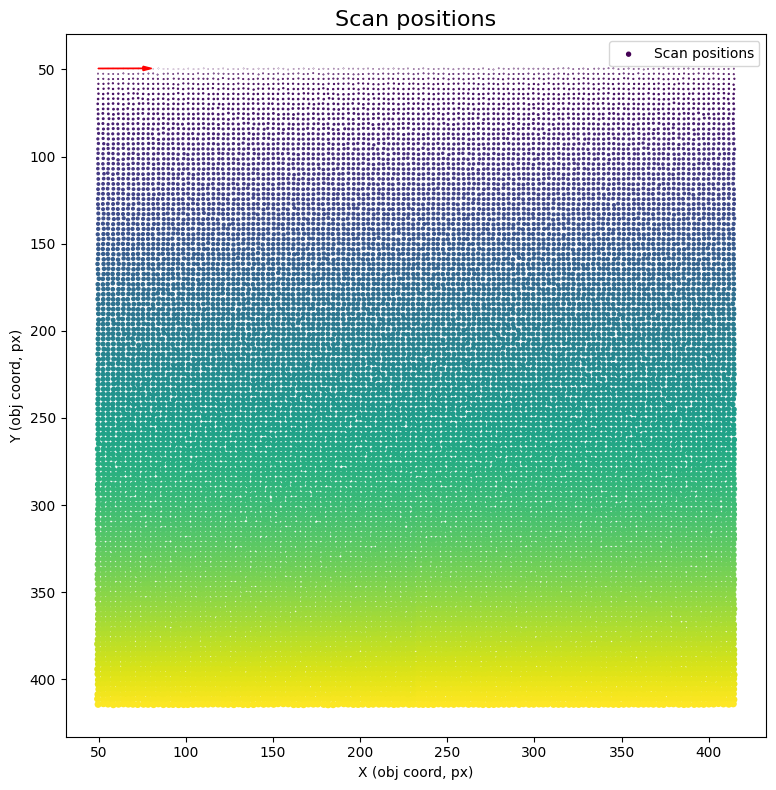

In [6]:
pos = init.init_variables["crop_pos"] + init.init_variables["probe_pos_shifts"]
plot_scan_positions(pos, figsize=(8, 8))

In [7]:
# model_params = {
#     'obj_preblur_std'     : None, # type: None or float, unit: px (real space). This applies Gaussian blur to the object before simulating diffraction patterns. Since the gradient would flow to the original "object" before blurring, it's essentially deconvolving the object with a Gaussian kernel of specified std. This sort of deconvolution can generate sharp features, but the usage is not easily justifiable so treat it carefully as a visualization exploration
#     'detector_blur_std'   : None, # type: None or float, unit: px (k-space). This applies Gaussian blur to the forward model simulated diffraction patterns to emulate the PSF of high-energy electrons on detector for experimental data. Typical value is 0-1 px (std) based on the acceleration voltage 
#     'optimizer_params'    : {'name': 'Adam', 'configs': None, 'load_state': None}, # Support all PyTorch optimizer except LBFGS because LBFGS can't set separate learning rates for different tensors. The suggested optimizer is 'Adam' with default configs (None). You can load the previous optimizer state by passing the path of `model.pt` to `load_state`, this way you can continue previous reconstruciton smoothly without abrupt gradients. (Because lots of the optimizers are adaptive and have history-dependent learning rate manipulation, so loading the optimizer state is necessary if you want to continue the previous optimization trajectory)
#     'update_params': {
#         'obja'            : {'start_iter': 1, 'lr': 5.0e-4}, # object amplitude
#         'objp'            : {'start_iter': 1, 'lr': 5.0e-4}, # object phase
#         'obj_tilts'       : {'start_iter': None, 'lr': 0}, # object tilts
#         'probe'           : {'start_iter': 1, 'lr': 1.0e-4},  # probe
#         'probe_pos_shifts': {'start_iter': 1, 'lr': 5.0e-4}, # sub-px probe positions
#     }
# }

model = PtychoAD(init.init_variables, model_params, device=DEVICE)
optimizer = create_optimizer(model.optimizer_params, model.optimizable_params)


### PtychoAD optimizable variables ###
obja            : torch.Size([1, 1, 592, 592])    , torch.float32   , device:cuda:0, grad:True , lr:5e-04
objp            : torch.Size([1, 1, 592, 592])    , torch.float32   , device:cuda:0, grad:True , lr:5e-04
obj_tilts       : torch.Size([1, 2])              , torch.float32   , device:cuda:0, grad:False, lr:0e+00
probe           : torch.Size([6, 128, 128])       , torch.complex64 , device:cuda:0, grad:True , lr:1e-04
probe_pos_shifts: torch.Size([16384, 2])          , torch.float32   , device:cuda:0, grad:True , lr:5e-04

### Optimizable variables statitsics ###
Total measurement values:    268,435,456                
Total optimizing variables:  832,000                
Overdetermined ratio:        322.64

### Model behavior ###
Obj preblur       : False
Tilt propagator   : False
Sub-px probe shift: True
Detector blur     : False

### Creating PyTorch 'Adam' optimizer with configs = {} ###


## Check the forward pass

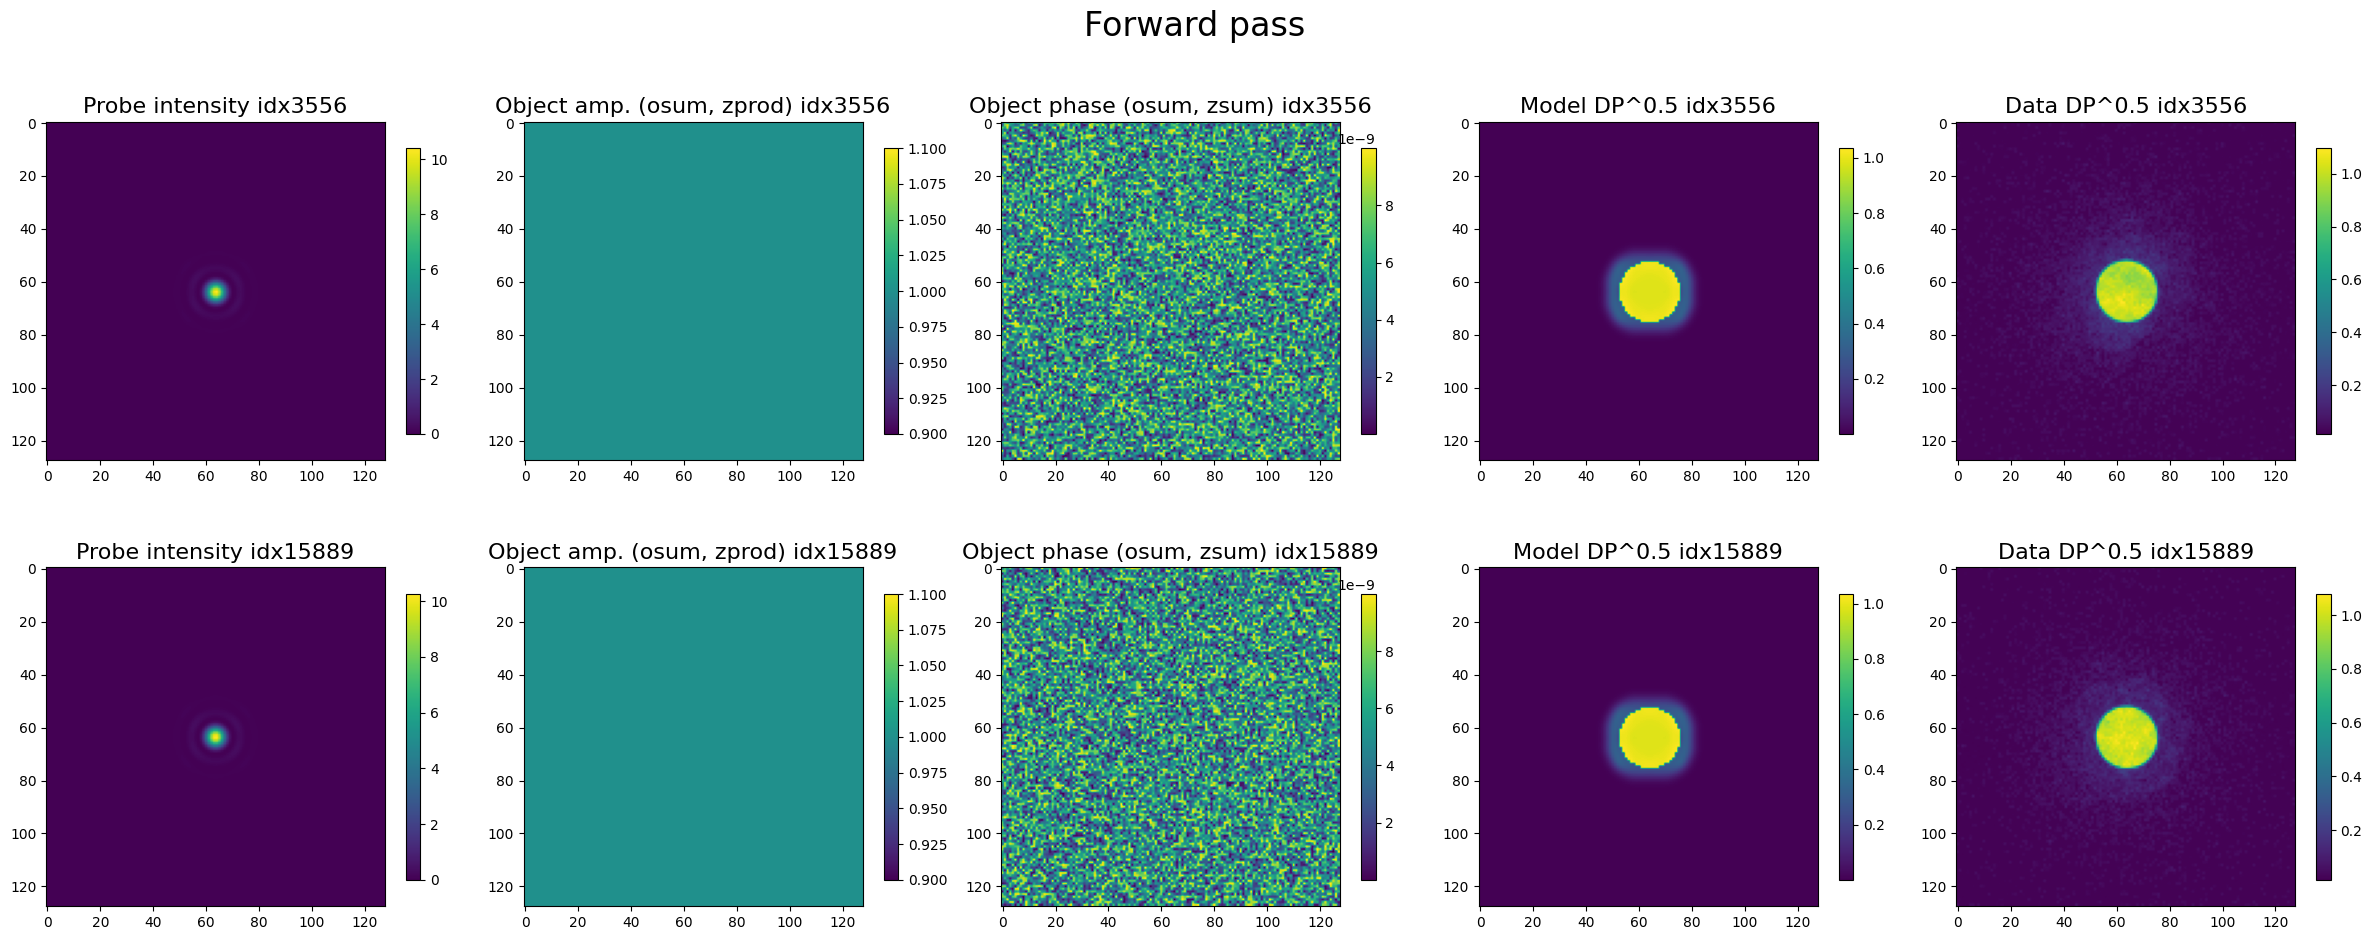

In [8]:
indices = np.random.randint(0, init.init_variables["N_scans"], 2)
dp_power = 0.5
plot_forward_pass(model, indices, dp_power)

## Finetune the loss params

In [12]:
# loss_params = {
#     'loss_single': {'state': True, 'weight': 1.0, 'dp_pow': 0.5}, # NRMSE error between single simulated and experimental diffraction pattern. 'dp_pow' is commonly set at 0.5 so NRMSE(DP_sim^0.5 - DP_exp^0.5) is equivalent to the Gaussian noise model for typical dataset (dose-sufficient) under the maximum-likelihood formalism
#     'loss_poissn': {'state': False, 'weight': 1.0, 'dp_pow': 1.0, 'eps': 1.0e-6}, # negative log likelihood between simulated and experimental diffraction pattern. 'dp_pow' is commonly set at 1 so - (DP_sim * (DP_exp) - DP_exp) is equivalent to the Poisson noise model for low dose dataset under maximum likelihood formalism. See Odstrˇcil2018 https://doi.org/10.1364/OE.26.003108 for more details
#     'loss_pacbed': {'state': False, 'weight': 0.5, 'dp_pow': 0.2}, # NRMSE error between simulated and experimental position-averaved CBED (PACBED). Similar to 'loss_single', except that it's comparing PACBED with PACBED and mostly focusing on the diffuse background when 'dp_pow' is set at 0.2
#     'loss_sparse': {'state': True, 'weight': 0.1, 'ln_order': 1}, # L_n norm regularization calculated for object phase. 'ln_order' means the L_n norm (|a_i^n|^(1/n)) used to regularize object phase ('objp'). Usually 'ln_order' is set at 1 for L1 norm (|a|), this promotes 0 in the objp and enhance the sparsity (i.e. discrete atoms). 'ln_order' = 2 would be equivalent to L2 norm that promotes near-0 values
#     'loss_simlar': {'state': False, 'weight': 0.1, 'obj_type': 'both', 'scale_factor': [1,1,1], 'blur_std': 1} # std across omode dimension for obj. This promotes similarity between object modes. 'obj_type' can be either 'amplitude', 'phase', or 'both'. 'scale_factor' as (zoom_z, zoom_y, zoom_x) is used to scale the object before calculating the std, setting 'scale_factor' to [1,0.5,0.5]  is equivalent to downsampling the obj 2x along y and x directions before calculating the std, which should encourage the obj modes to keep lateral atom shifts. Similarly, 'blur_std' applies a 2D (lateral) Gaussian blur kernel with specified std to blur the obj before calculating std along omode dimension
# }

indices = np.random.randint(0, init.init_variables["N_scans"], 16)
loss_fn = CombinedLoss(loss_params, device=DEVICE)
test_loss_fn(model, indices, loss_fn)

loss_single: 0.72554612
loss_poissn: 0.00000000
loss_pacbed: 0.00000000
loss_sparse: 0.00000000
loss_simlar: 0.00000000


# Setup the iteration-wise constraint params

In [10]:
# constraint_params = {
#     'ortho_pmode'   : {'freq': 1}, # Apply a SVD decomposition and orthogonalization of the mixed-state probe similar to the PtychoShelves implementation (except it's vectorized in PtyRAD). Turn this on when optimizing with mixed-state probe
#     'probe_mask_k'  : {'freq': None, 'radius': 0.22, 'width': 0.05, 'power_thresh': 0.95}, # Apply a k-space sigmoid (similar to a top-hat) probe mask that cut off spatial frequencies beyond the probe-forming aperture. This prevents the probe from absorbing the object structure in k-space. It might cause high-frequency oscillations in the real-space object if you have strong diffuse background in the diffraction pattern and did not provide mixed-object to properly reproduce it. Recommend setting it to 'None' unless you're pursuing mixed-object with more physical probes. k-radius should be larger than 2*rbf/Npix to avoid cutting out the BF disk. 'radius' and 'width' are used to define the sigmoid funciton in relative unit with kMax. See 'utils/make_sigmoid_mask' for more details. 'power_thresh' is used to specify how far into the pmode should be masked. If 'power_thresh': 0.95, the k-space mask would be applied from strongest probe modes to the one that adds uo to 95% total intensity. This promotes a more physical mixed-probe while keeping a small fraction of probe modes to absorb unexpected errors.
#     'fix_probe_int' : {'freq': 1}, # Rescale the probe intensity to make it consistent with the total diffraction pattern intensity (so every probe electron hits on the detector). This is needed to stabilize the object amplitude update because the probe update could potentially change the total intensity. This removes the scaling constant ambiguity between probe and object, and should be applied if you're simultaneously optimizing the probe and object amplitude
#     'obj_rblur'     : {'freq': None, 'obj_type': 'both', 'kernel_size': 5, 'std': 0.2}, # Apply a "lateral" 2D Gaussian blur to the object. This removes some high frequency noise in the reconstructed object and make the apperance smoother. 'obj_type' can be either 'amplitude', 'phase', or 'both' with a specified 'std' and 'kernel_size' in unit of real-space px. Ideally kernel size is odd (like 5) and larger than 6std+1 so it decays to 0. This is usually not needed if your dataset contains sufficient dose and the kMax is not insanely high (extremely high kMax would gives very fine dx which makes feature appear sharper and probably more seemingly noisy)
#     'obj_zblur'     : {'freq': None, 'obj_type': 'both', 'kernel_size': 5, 'std': 1}, # Apply a "z-direction" 1D Gaussian blur to the object. This is a real-space alternative to the typical kz_filter (or so called missing-wedge regularization that applies Fourier filtering to the object) designed for multislice ptychography. Similar to 'obj_rblur', 'obj_type' can be either 'amplitude', 'phase', or 'both' with a specified 'std' and 'kernel_size' in unit of real-space px. Note that the 'ptycho/engines/GPU_MS/private/regulation_multilayers.m' from PtychoShelves (fold_slice) is a combination of 'obja_thresh', 'kr_filter', and 'kz_filter', so you may want to activate all these constraints altogether in PtyRAD to get the most similar effect 
#     'kr_filter'     : {'freq': None, 'obj_type': 'both', 'radius': 0.15, 'width': 0.05}, # Apply a "lateral" Fourier low-pass filtering to the object. This is similar to the band-pass filter in Digital Micrograph that the k-space filter has a sigmoid-like profile, essentially a cut-off spatial frequency. Typically we're reconstucting object all the way to kMax (Nyquist frequency) so there's not much room for us to filter out hence it's recommended to keep this off unless you want to exclude certain spatial frequencies. 'radius' and 'width' are used to define the sigmoid funciton in relative unit with kMax. See 'utils/make_sigmoid_mask' for more details
#     'kz_filter'     : {'freq': None, 'obj_type': 'both', 'beta': 0.1, 'alpha': 1}, # Apply the arctan kz filter just like the 'regulation_multilayers.m' in PtychoShelves. 'beta' controls the strength of the arctan function and is the same as 'eng. regularize_layers' in PtychoShelves. Typical value of 'beta' ranges from 0 to 1. 'alpha' is the implicit constant controls the lateral Fourier filtering that has similar effect as 'kr_filter', usually set as 1 to be consistent with PtychoShelves. Note that 'kz_filter' is designed to be a PtyRAD equivalence of the 'regulation_multilayers.m' so it also includes the arctan Fourier filer, lateral Fourier filter, and the soft object amplitude thresholding if you set 'obj_type' to 'both'. See 'optimization/kz_filter' for more details. While this 'kz_filter' works very well for most multislice reconstructions of crystals, you might prefer 'obj_zblur' if you have an object that has distinct top and bottom layer like twisted bilayer or tilted systems because 'kz_filter' would introduce intermixing between the top and bottom layer due to the periodic boundary condition of Fourier transform. Another solution to the intermixing is to pad vacuum layers to your object and remove them later, although padding extensive vacuum layers tend to make object phase bleed into the vacuum layers and it's very hard to set the interface
#     'obja_thresh'   : {'freq': None, 'relax': 0, 'thresh': [0.98, 1.02]}, # Apply a thresholding of object amplitude around 1. The threshold is defined by 'thresh' and the value is determined by the min and max. Note that wave amplitude is multiplicative when propagating through multislice object, so even an objective amplitude of 0.95 can become 0.6 after 10 layers. The thresholding can be relaxed by the `relax` param that is a weighted sum betwen the pre-threshold and post-threshold values.
#     'objp_postiv'   : {'freq': 1,    'relax': 0}, # Apply a positivity constraint of the object phase, make it non-negative. This clips the negative values (anything below 0) so the object is visually darker but with stronger constrast, it's suggested to keep it on so that you can interpret, compare, and process your object phase with a simple baseline. Besides, the positivity constraint makes it easier to compare with atomic potential ground truth after correct scaling for the scattering factor. The clipping can be relaxed by the `relax` param that is a weighted sum betwen the pre-threshold and post-threshold values.
#     'tilt_smooth'   : {'freq': None, 'std': 2} # Apply a lateral Gaussian blur of the local object tilts in unit of "scan positions". This smoothens the local tilts so that you don't have drastic changes of object tilts between scan positions.
# }

constraint_fn = CombinedConstraint(constraint_params, device=DEVICE)

# 03. Main optimization loop

In [ ]:
# recon_params= {
#     'NITER': 5, # type: int. Total number of reconstruction iterations. 1 iteration means a full pass of all selected diffraction patterns. Usually 20-50 iterations can get 90% of the work done with a proper learning rate between 1e-3 to 1e-4. For faster trials in hypertune mode, set 'NITER' to a smaller number than your typical reconstruction to save time. Usually 10-20 iterations are enough for the hypertune parameters to show their relative performance. 
#     'INDICES_MODE': {'mode': 'full', 'subscan_slow': None, 'subscan_fast': None}, # type: dict. Indices mode determines multiple ways to use diffraction patterns at each probe positions for reconstructions. Each probe position (or each diffraction pattern) has a unique index, by selecting a subset of the indices, we can conveniently change the effective reconstruction area ('center') or effective scan step size or real space overlap ('sub'). You may choose 'full' for reconstructing with all probe positions, 'sub' for subsampling by selecting only every few probe positions with the full FOV (i.e., this will increase the effective scan step size and is a good way to test whether we can reduce the real space overlap), or 'center' for only using the center rectangular region in real space with a effectively reduced FOV but full sized object canvas. 'subscan_slow' and 'subscan_fast' determine the number of scan positions chosen for 'sub' and 'center', and have no effect to 'full'. If 'subscan_slow' and 'subscan_fast' are not provided (or None), they'll be set to half of the 'N_scan_slow' and half of the 'N_scan_fast' by default. Typically we can start from 'INDICES_MODE': {'mode': 'sub', 'subscan_slow: None, 'subscan_fast': None} to get an quick idea of the entire object by reconstructing the entire object FOV but using only every other diffraction pattern along fast and slow scan directions (so only 1/4 diffraction patterns are used, hence 4x speedup in the iteration time). Similarly we can use 'center' to keep the effective scan step size, but reconstruct a smaller FOV. Once the 'sub' or 'center' show reasonable results, we can then switch to 'full' to further refine it without starting from scratch because there's no object dimension mismatch between the 'INDICES_MODEs'.
#     'BATCH_SIZE': {'size': 32, 'grad_accumulation': 1}, # type: dict. Batch size is the number of diffraction patterns processed simultaneously to get the gradient update. 'size' is the number of diffraction pattern in a sub-batch, and 'grad_accumulation' is how many sub-batches' gradients are accumulated before applying the update. Effective batch size (for 1 update) is batch_size * grad_accumulation. Gradient accumulation is a ML technique that allows people to use large effective batch size by trading the iteration time with memory requirement, so if you can fit the entire batch inside your memory, you should always set 'grad_accumulation': 1 for performance. "Batch size" is commonly used in machine learning community, while it's called "grouping" in PtychoShelves. Batch size has an effect on both convergence speed and final quality, usually smaller batch size leads to better final quality for iterative gradient descent, but smaller batch size would also lead to longer computation time per iteration because the GPU isn't as utilized as large batch sizes (due to less GPU parallelism). On the other hand, large batch size is known to be more robust (noise-resilient) but converges slower. Generally batch size of 32 to 128 is used, although certain algorithms (like ePIE) would prefer a large batch size that is equal to the dataset size for robustness. For extremely large object (or with a lot of object modes), you'll need to reduce batch size to save GPU memory, or use `grad_accumulation` to split a batch into multiple sub-batches for 1 update.
#     'GROUP_MODE': 'random',  # type: str. Group mode determines the spatial distribution of the selected probe positions within a batch (group), this is similar to the 'MLs' for 'sparse' and 'MLc' for 'compact' in PtychoShelves. Available options are 'random', 'sparse', and 'compact'. Usually 'random' is good enough with small batch sizes and is the suggested option for most cases. 'compact' is believed to provide best final quality, although it's converging much slower. 'sparse' gives the most uniform coverage on the object so converges the fastest, and is also preferred for reconstructions with few scan positions to prevent any locally biased update. However, 'sparse' for 256x256 scan could take more than 10 mins on CPU just to compute the grouping, hence PtychoShelves automatically switches to 'random' for Nscans > 1e3. The grouping in PtyRAD is fixed during optimization, but the order between each group is shuffled for every iteration.
#     'SAVE_ITERS': 5,  # type: None or int. Number of completed iterations before saving the current reconstruction results (model, probe, object) and summary figures. If 'SAVE_ITERS' is 50, it'll create an output reconstruction folder and save the results and figures into it every 50 iterations. If None, the output reconstruction folder would not be created and no reconstruction results or summary figures would be saved. If 'SAVE_ITERS' > 'NITER', it'll create the output reconstruction folder but no results / figs would be saved. Typically we set 'SAVE_ITERS' to 50 for reconstruction mode with 'NITER' around 200 to 500. For hypertune mode, it's suggested to set 'SAVE_ITERS' to None and set 'collate_results' to true to save the disk space, while also provide an convenient way to check the hypertune performance by the collated results.
#     'output_dir': 'output/tBL-WSe2/', # type str. Path and name of the main output directory. Ideally the 'output_dir' keeps a series of reconstruction of the same materials system or project. The PtyRAD results and figs will be saved into a reconstruction-specific folder under 'output_dir'. The 'output_dir' folder will be automatically created if it doesn't exist.
#     'recon_dir_affixes': ['optimizer', 'start_iter', 'lr', 'model', 'constraint', 'loss'], # type: list of strings. This list specifies the optional affixes to the reconstruction folder name. The order of strings has NO effect to the output folder name. Available options are 'optimizer', 'start_iter', 'lr', 'model', 'constraint', 'loss', and 'init'. Note that the reconstruction folder should be distinct for each reconstruction run so the results don't get put into the wrong folder. 'optimizer' would affix the name of the PyTorch optimizer. 'start_iter' would affix the iteration at which optimizable variables start being updated by AD. 'lr' would affix the learning rate information. 'constrain', 'model' would affix the std from 'obj_preblur_std' and 'detector_blur_std' under 'model_params' if they're used. 'loss' would affix the activated loss term and their weights. 'init' would affix the initialization parameters like 'conv_angle', 'defocus', 'scan_affine', 'init_tilts' that could potentially be hypertuned. Note that all the affixes can be applied for both reconstruction and hypertune mode, it's just clearer to include 'init' if you're running hypertune mode that may optimize on some initial parameters.
#     'prefix_date': True, # type: boolean. Whether to prefix a date str to the reconstruction folder or not. Set to true to automatically prefix a date str like '20240903_' in front of the reconstruction folder name. Suggested value is true for both reconstruction and hypertune modes. In hypertune mode, the date string would be applied on the hypertune folder instead of the reconsstruction folder. 
#     'prefix': '', # type: str. Prefix this string to the reconstruction folder name. Note that "_" will be automatically generated, and the attached str would be after the date str if 'prefix_date' is true. In hypertune mode, the prefix string would be applied on the hypertune folder instead of the reconsstruction folder.  
#     'postfix': '', # type: str. Postfix this string to the reconstruction folder name. Note that "_" will be automatically generated. In hypertune mode, the postfix string would be applied on the hypertune folder instead of the reconsstruction folder.  
#     'save_result': ['model', 'obja', 'objp', 'probe'], # type: list of strings. This list specifies the available results to save. Available options are 'model', 'obja', 'objp', and 'probe'. 'model' is the pytorch dict stored as hdf5 with '.pt' file extension. 'model' contains optimizable tensors and metadata so that you can always refine from it and load whatever optimizable tensors (object, probe, positions, tilts) if you want to continue the reconstruction. It's similar to the NiterXXX.mat from PtychoShelves. 'object' and 'probe' output the reconstructed object and probe as '.tif'. If you don't want to save anything, set 'SAVE_ITERS' to None. Suggested setting is to save everything (i.e., ['model', 'obja', 'objp', 'probe']). For hypertune mode, you can set 'collate_results' to true and set 'SAVE_ITERS' to None to disable result saving.
#     'result_modes': {'obj_dim': [2, 3, 4], 'FOV': ['crop'], 'bit': ['raw', '8']}, # type: dict. This dict specifies which object output is saved by their final dimension ('obj_dim'), whether to save the full or cropped FOV ('FOV') of object, and whether to save the raw or normalized bit depth version of object and probe. A comprehensive (but probably redundant) saving option looks like {'obj_dim': [2,3,4], 'FOV': ['full', 'crop'], 'bit': ['raw', '32', '16', '8']}. 'obj_dim' takes a list of int, the int ranges between 2 to 4, corresponding to 2D to 4D object output. Set 'obj_dim': [2] if you only want the zsum from multislice ptychography. Suggested value is [2,3,4] to save all possible output. 'FOV' takes a list of strings, the available strings are either 'full' or 'crop'. Suggested value is 'crop' so the lateral padded region of object is not saved. 'bit' takes a list of strings, the available strings are 'raw', '32', '16', and '8'. 'raw' is the original value range, while '32' normalizes the value from 0 to 1. '16' and '8' will normalize the value from 0 to 65535 and 255 correspondingly. Defualt is '8' to save only the normalized 8bit result for quick visualization. You can set it to ['raw', '8'] if you want to keep the original float32 bit results with normalized 8bit results. These postprocessing would postfix corresponding labels to the result files.
#     'selected_figs': ['loss', 'forward', 'probe_r_amp', 'probe_k_amp', 'probe_k_phase', 'pos'], # type: list of strings. This list specified the selected figures that will be plotted/saved. The available strings are 'loss', 'forward', 'probe_r_amp', 'probe_k_amp', 'probe_k_phase', 'pos', 'tilt', and 'all'. The suggested value is ['loss', 'forward', 'probe_r_amp', 'probe_k_amp', 'probe_k_phase', 'pos'].
#     'copy_params': True, # type: boolean. Set to true if you want to copy the .yml params file to the hypertune folder (hypertune mode) or individual reconstruction folders (reconsturction mode). Suggested value is true for better record keeping, although most information is saved in model.pt and can be loaded by ckpt = torch.load('model.pt'), params = ckpt['params'].
#     'if_quiet': False, # type: boolean. Set to true if you want to reduce the amount of printed information during PtyRAD reconstruction. Suggested value is false for more information, but if you're running hypertune mode you should consider setting it to true.
# }

NITER             = recon_params['NITER']
INDICES_MODE      = recon_params['INDICES_MODE']
batch_size        = recon_params['BATCH_SIZE'].get("size")
grad_accumulation = recon_params['BATCH_SIZE'].get("grad_accumulation")
GROUP_MODE        = recon_params['GROUP_MODE']
SAVE_ITERS        = recon_params['SAVE_ITERS']
output_dir        = recon_params['output_dir']
recon_dir_affixes = recon_params['recon_dir_affixes']
prefix_date       = recon_params['prefix_date']
prefix            = recon_params['prefix']
postfix           = recon_params['postfix']
save_result       = recon_params['save_result']
result_modes      = recon_params['result_modes'] 
selected_figs     = recon_params['selected_figs']
copy_params       = recon_params['copy_params']



pos = (model.crop_pos + model.opt_probe_pos_shifts).detach().cpu().numpy()
probe_int = model.opt_probe[0].abs().pow(2).detach().cpu().numpy()
dx = init.init_variables["dx"]
d_out = get_blob_size(dx, probe_int, output="d90")  # d_out unit is in Ang

indices = select_scan_indices(
    init.init_variables['N_scan_slow'],
    init.init_variables['N_scan_fast'],
    subscan_slow=INDICES_MODE['subscan_slow'],
    subscan_fast=INDICES_MODE['subscan_fast'],
    mode=INDICES_MODE['mode'],
)

batches = make_batches(indices, pos, batch_size, mode=GROUP_MODE)
print(f"The effective batch size (i.e., how many probe positions are simultaneously used for 1 update of ptychographic parameters) is batch_size * grad_accumulation = {batch_size} * {grad_accumulation} = {batch_size*grad_accumulation}")


fig_grouping = plot_pos_grouping(
    pos,
    batches,
    circle_diameter=d_out / dx,
    diameter_type="90%",
    dot_scale=1,
    show_fig=True,
    pass_fig=True,
)

if SAVE_ITERS is not None:
    output_path = make_output_folder(
        output_dir,
        indices,
        exp_params,
        recon_params,
        model,
        constraint_params,
        loss_params,
        recon_dir_affixes
    )
    
    fig_grouping.savefig(output_path + "/summary_pos_grouping.png")

    if copy_params:
        copy_params_to_dir(params_path, output_path)

In [ ]:
start_t = time_sync()
print("\n### Starting the PtyRADSolver in reconstruction mode ###")

loss_iters = []
for niter in range(1, NITER + 1):

    shuffle(batches)
    batch_losses, iter_t = recon_step(
        batches, grad_accumulation, model, optimizer, loss_fn, constraint_fn, niter
    )
    loss_iters.append((niter, loss_logger(batch_losses, niter, iter_t)))

    ## Saving intermediate results
    if SAVE_ITERS is not None and niter % SAVE_ITERS == 0:
        # Note that `exp_params` stores the initial exp_params, while `model` contains the actual params that could be updated if either meas_crop or meas_resample is not None
        save_results(
            output_path,
            model,
            params,
            optimizer,
            loss_iters,
            iter_t,
            niter,
            indices,
            batch_losses,
        )

        ## Saving summary
        plot_summary(
            output_path,
            model,
            loss_iters,
            niter,
            indices,
            init.init_variables,
            selected_figs=selected_figs,
            show_fig=False,
            save_fig=True,
        )
        
end_t = time_sync()
solver_t = end_t - start_t
time_str = f", or {parse_sec_to_time_str(solver_t)}" if solver_t > 60 else ""
print(f"\n### The PtyRADSolver is finished in {solver_t:.3f} sec {time_str} ###")